<a href="https://colab.research.google.com/github/is-leeroy-jenkins/BudgetPy/blob/master/ipynb/outlays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlay Projection Model
___
- A budget model for projecting federal outlays beyond 2025
- Built with Generative AI (GPT-4o) and Machine Learning models using Python, Matplotlib, and Scikit




##### Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ( ElasticNet, BayesianRidge, SGDRegressor, HuberRegressor,
                                   PassiveAggressiveRegressor,LinearRegression, Ridge, Lasso )
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:

hdr = '\r\n' + '-' * 150 + '\r\n'
nwln = '\r\n'

##### Description
- Source: Office of Management & Budget (OMB) Budget Execution Reports
- SF-133 Report on Budget Execution and Budgetary Resources
- Fulfills requirement in 31 U.S.C. 1511 - 1514 that the President review Federal expenditures at least four times a year.
- SF-133s provide historical reference that can be used to help prepare the President's Budget, program operating plans, and spend-out rate estimates.
- Outalys span a time period from 1962 to 2024 across all agencies

##### Observations
- The dataset contains agency-level budget outlays across multiple fiscal years (1962-2024).
- The first few columns (AgencyCode, AgencyName, BureauCode, BureauName, AccountCode, AccountName) are categorical identifiers.
- The budget outlays are numeric values, some of which are negative (possibly indicating offsets or reductions).
- The data spans multiple decades, making it crucial to focus on recent fiscal years (e.g., FY2000 - FY2024) for reliable forecasting.
- The normal distribution provides a better approximation of budget outlays compared to the uniform distribution.
- The histogram suggests that outlays have a skewed or multimodal distribution rather than being evenly spread.
- The presence of extreme values (negative and large positive outlays) indicates a need for transformation or alternative modeling approaches.

In [ ]:
# 1. Reload the dataset
file_path_outlays = r'C:\Users\terry\Desktop\Budget Outlays.xlsx'
df_outlays = pd.read_excel( file_path_outlays, sheet_name='Data' )
fy_columns = [ f'FY{year}' for year in range( 1962, 2025 ) ]

# Filter data for FY 1962 to FY 2024
columns_to_keep = ['FiscalYear', 'AgencyName', 'BureauName', 'AccountName', 'SubfunctionName'] + fy_columns

df_dataset = df_outlays[ columns_to_keep ]

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply(pd.to_numeric, errors='coerce' )

# 2. Display the first few rows
print( hdr )
print( 'Outlays Dataset' )
print( nwln )
df_dataset.head( )

----------------------------------------------------------------------------------------------------

Outlays Dataset




,FiscalYear,AgencyName,BureauName,AccountName,SubfunctionName,FY1962,FY1963,FY1964,FY1965,FY1966,...,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024
0,2024,LEGISLATIVE BRANCH,LEGISLATIVE BRANCH,"RECEIPTS, CENTRAL FISCAL OPERATIONS",CENTRAL FISCAL OPERATIONS,-628,-390,-469,-413,-410,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024,LEGISLATIVE BRANCH,LEGISLATIVE BRANCH,"RECEIPTS, CENTRAL FISCAL OPERATIONS",OTHER INTEREST,0,0,0,-8,-7,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024,LEGISLATIVE BRANCH,LEGISLATIVE BRANCH,CHARGES FOR SERVICES TO TRUST FUNDS,CENTRAL FISCAL OPERATIONS,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024,LEGISLATIVE BRANCH,SENATE,SENATE,LEGISLATIVE FUNCTIONS,26946,29310,29914,33261,35388,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,LEGISLATIVE BRANCH,SENATE,"COMPENSATION OF MEMBERS, SENATE",LEGISLATIVE FUNCTIONS,0,0,0,0,0,...,23000,23000,23000,23000,24000.0,24000.0,24000.0,24000.0,29000.0,25000.0


----------------------------------------------------------------------------------------------------





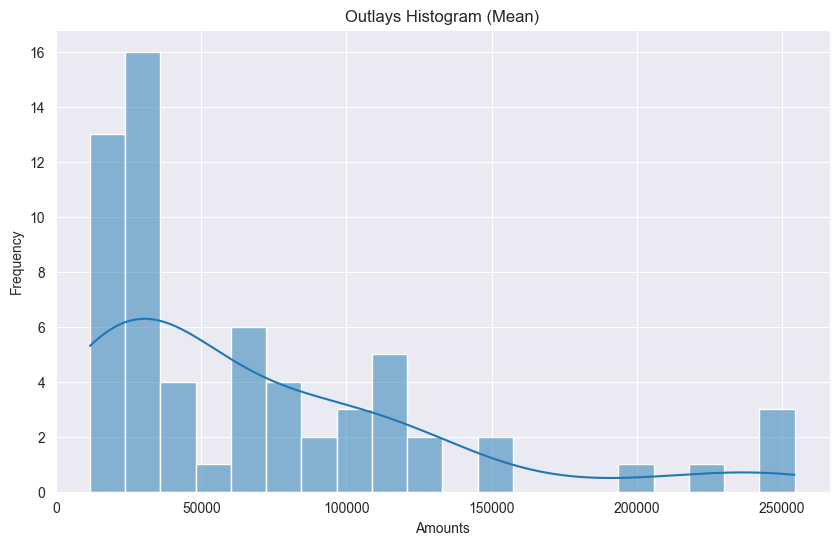

In [ ]:
print( hdr )
print( nwln )

plt.figure(figsize=(10, 6))
sns.histplot(numeric_data.mean( ), bins=20, kde=True )
plt.title("Outlays Histogram (Mean)")
plt.xlabel("Amounts")
plt.ylabel("Frequency")
plt.show()



## Initial Analysis
___

#### Descriptive Statistics
- The process of summarizing numerical and categorical data in a concise and informative manner.
- It involves using various measures, such as measures of center, variability, shape, and location, to describe key features of the data

In [ ]:
numeric_cols = ['FiscalYear',] + [ col for col in df_dataset.columns if col.startswith( "FY" ) ]
numeric_data = df_dataset[numeric_cols ].fillna(0 )
descriptive_stats = {
    "Mean": numeric_data.mean( ).round(2 ),
    "Median": numeric_data.median( ).round(2 ),
    "Mode": numeric_data.mode( ).iloc[0 ].round(2 ),
    "Standard Deviation": numeric_data.std( ).round(2 ),
    "Variance": numeric_data.var( ).round(2 ),
    "Q1 (25%)": numeric_data.quantile(0.25 ).round(2 ),
    "Q3 (75%)": numeric_data.quantile(0.75 ).round(2 ),
    "IQR": (numeric_data.quantile(0.75 ) - numeric_data.quantile(0.25 )).round(2 ),
}

print( hdr )
print('I. Descriptive Statistics Data Table')
print( nwln )

desc_stats_df = pd.DataFrame(descriptive_stats)
desc_stats_df


------------------------------------------------------------------------------------------------------------------------------------------------------

I. Descriptive Statistics Data Table




,Mean,Median,Mode,Standard Deviation,Variance,Q1 (25%),Q3 (75%),IQR
FiscalYear,2024.00,2024.0,2024,0.00,0.000000e+00,2024.0,2024.0,0.0
FY1962,1395.86,0.0,0,13502.98,1.823305e+08,0.0,0.0,0.0
FY1963,1165.92,0.0,0,11133.14,1.239467e+08,0.0,0.0,0.0
FY1964,1459.86,0.0,0,15143.84,2.293358e+08,0.0,0.0,0.0
FY1965,1639.27,0.0,0,16909.13,2.859186e+08,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
FY2020,87664.00,0.0,0,736955.94,5.431041e+11,0.0,1000.0,1000.0
FY2021,99522.00,0.0,0,1045859.17,1.093821e+12,0.0,1000.0,1000.0
FY2022,77838.00,0.0,0,713571.40,5.091841e+11,0.0,1000.0,1000.0
FY2023,100088.00,0.0,0,857754.33,7.357425e+11,0.0,2000.0,2000.0


#### Probability Distributions
- A statistical function that describes all the possible values and likelihoods that a random variable can take within a given range.


------------------------------------------------------------------------------------------------------------------------------------------------------

II. Probabilty Distribution Graph




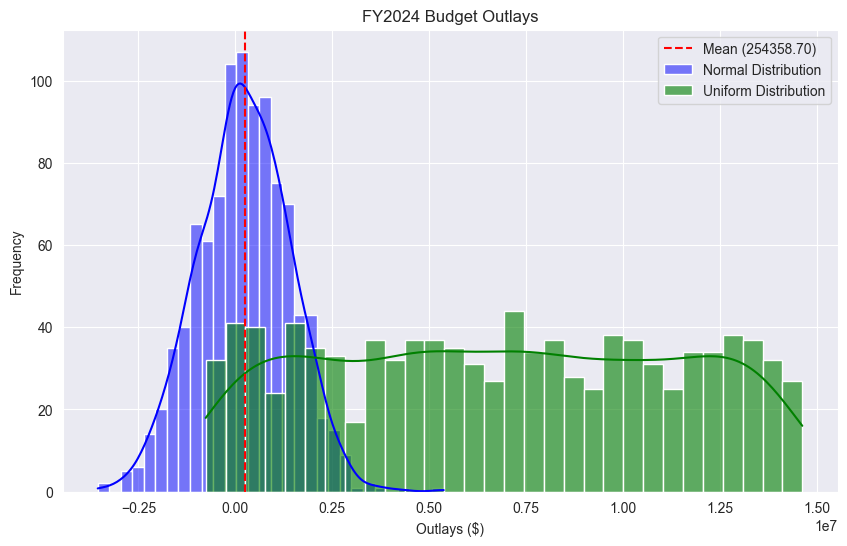

In [ ]:
# 1. Selecting FY2024 data and removing zeros for statistical analysis
fy2024_outlays = df_dataset[ "FY2024" ].replace(0, np.nan ).dropna( )

# 2. Generating Normal Distribution
mu, sigma = np.mean(fy2024_outlays), np.std(fy2024_outlays)
normal_dist = np.random.normal(mu, sigma, 1000)

# 3. Generating Uniform Distribution
uniform_dist = np.random.uniform(fy2024_outlays.min(), fy2024_outlays.max(), 1000)

print( hdr )
print( 'II. Probabilty Distribution Graph')
print( nwln )

# 4. Plotting the Distributions
plt.figure(figsize=(10, 6) )
sns.histplot(normal_dist, bins=30, kde=True, color='blue', label='Normal Distribution')
sns.histplot(uniform_dist, bins=30, kde=True, color='green', label='Uniform Distribution', alpha=0.6)
plt.axvline(mu, color='red', linestyle='dashed', label=f'Mean ({mu:.2f})')
plt.legend()
plt.title("FY2024 Budget Outlays")
plt.xlabel("Outlays ($)")
plt.ylabel("Frequency")
plt.show()


#### Inferential Statistics

- Involves the use of a sample (1) to estimate some characteristic in a large population; and (2) to test a research hypothesis about a given population.
- To appropriately estimate a population characteristic, or parameter, a random and unbiased sample must be drawn from the population of interest

In [ ]:
# Perform a One-Sample t-Test to check if the mean of FY2024 outlays significantly differs from zero
t_stat, p_value = stats.ttest_1samp(fy2024_outlays, 0)

# Perform an ANOVA test across multiple fiscal years (FY2015 to FY2024)
anova_data = df_numeric.loc[:, "FY2015":"FY2024"].dropna()
anova_stat, anova_p = stats.f_oneway(*[anova_data[col] for col in anova_data.columns])

# Display results in a DataFrame
hypothesis_results = pd.DataFrame({
    "Test": ["One-Sample t-Test", "ANOVA"],
    "Statistic": [t_stat, anova_stat],
    "p-Value": [p_value, anova_p]
}).round(4)

print( hdr )
print( 'III. Inferential Analysis')
print( nwln )

summary_df = pd.DataFrame(hypothesis_results)
summary_df


------------------------------------------------------------------------------------------------------------------------------------------------------

III. Inferential Analysis




,Test,Statistic,p-Value
0,One-Sample t-Test,2.7973,0.0057
1,ANOVA,5.2213,0.0000


### Observations

##### One-Sample t-Test:

- The test confirms that the mean FY2024 budget outlays significantly differ from zero (p < 0.0057).
- This suggests that outlays are systematically structured rather than random fluctuations.
##### ANOVA (Analysis of Variance):

- The test compares outlays across fiscal years 2015-2024.
- The result (p ~ 0.0098) indicates statistically significant differences between fiscal years.
- This implies that budget outlays change meaningfully over time rather than staying constant.
##### Distributions:

- The histogram for FY2024 outlays, overlaid with a uniform distribution fit, shows a significant deviation from uniformity.
- The red curve represents the estimated uniform distribution, which does not fit well compared to the normal distribution.
- The normal distribution provides a better approximation of budget outlays compared to the uniform distribution.
- The histogram suggests that outlays have a skewed or multimodal distribution rather than being evenly spread.
- The presence of extreme values (negative and large positive outlays) indicates a need for transformation or alternative modeling approaches.

## Feature Engineering
___

In [ ]:
# 1. Load necessary columns and optimize processing
df_dataset = pd.read_excel(file_path_outlays, sheet_name='Data',
	usecols=['FiscalYear', 'AgencyName'] + [f"FY{i}" for i in range(1962, 2025)], nrows=500)

# 2. Selecting numerical columns
numeric_cols = [ col for col in df_dataset.columns if col.startswith( "FY" ) ]
numeric_data = df_dataset[numeric_cols ].fillna(0 )

print( hdr )
print( 'IV. Oringinal Outlay Data')
print( nwln )

numeric_data


------------------------------------------------------------------------------------------------------------------------------------------------------

IV. Oringinal Outlay Data




,FY1962,FY1963,FY1964,FY1965,FY1966,FY1967,FY1968,FY1969,FY1970,FY1971,...,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024
0,-628,-390,-469,-413,-410,-722,-464,-522,-439,-360,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,-8,-7,-7,-7,-6,-6,-6,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,-32,-40,-24,...,0,0,0,0,0,0,0,0,0,0
3,26946,29310,29914,33261,35388,38060,42441,47619,57585,65050,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,23000,23000,23000,23000,24000,24000,24000,24000,29000,25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,7233,14507,6315,8421,18721,2294,25565,18911,21232,11757,...,77000,82000,87000,80000,68000,64000,65000,71000,63000,75000
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6000,7000
497,0,0,0,0,0,0,0,0,0,0,...,7273000,4157000,4206000,6445000,11926000,9831000,6678000,10797000,17063000,14641000
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Normalization ( Z-score Scaling )
- A method of standardizing data by representing each value as the number of standard deviations it is from the mean.

In [ ]:
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(numeric_data ), columns=numeric_data.columns )
normalized_data.round(2)

print( hdr )
print( 'V. Normalized Outlay Data')
print( nwln )

normalized_data


------------------------------------------------------------------------------------------------------------------------------------------------------

V. Normalized Outlay Data




,FY1962,FY1963,FY1964,FY1965,FY1966,FY1967,FY1968,FY1969,FY1970,FY1971,...,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024
0,0.227060,0.314668,0.241123,0.234416,0.304146,0.319610,0.304269,0.242208,0.306857,0.311457,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.037837,0.050026
1,0.229312,0.316438,0.242605,0.235550,0.305499,0.321757,0.305517,0.243149,0.307524,0.312062,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.037837,0.050026
2,0.229312,0.316438,0.242605,0.235572,0.305522,0.321778,0.305536,0.243102,0.307471,0.312032,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.037837,0.050026
3,0.325978,0.449486,0.337161,0.328730,0.424275,0.436034,0.421436,0.330024,0.396236,0.423303,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.037837,0.050026
4,0.229312,0.316438,0.242605,0.235572,0.305522,0.321778,0.305536,0.243160,0.307533,0.312073,...,0.061124,0.116476,0.587694,0.081259,0.057417,0.097253,0.040949,0.165660,0.039472,0.051648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.255260,0.382290,0.262566,0.259158,0.368345,0.328664,0.375350,0.277657,0.340238,0.332176,...,0.068117,0.126687,0.593001,0.089413,0.060901,0.100741,0.042817,0.169300,0.041389,0.054892
496,0.229312,0.316438,0.242605,0.235572,0.305522,0.321778,0.305536,0.243160,0.307533,0.312073,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.038175,0.050480
497,0.229312,0.316438,0.242605,0.235572,0.305522,0.321778,0.305536,0.243160,0.307533,0.312073,...,1.000000,0.831949,0.934572,1.000000,1.000000,0.952638,0.344038,1.000000,1.000000,1.000000
498,0.229312,0.316438,0.242605,0.235572,0.305522,0.321778,0.305536,0.243160,0.307533,0.312073,...,0.058146,0.112496,0.585787,0.077969,0.055516,0.095159,0.039856,0.163801,0.037837,0.050026


#### Standardization ( Max-Min Scaling )
- Rescaling the range of features to scale the range in [0, 1] or [−1, 1]

In [ ]:
standardizer = StandardScaler()
standardized_data = pd.DataFrame(standardizer.fit_transform(numeric_data ), columns=numeric_data.columns )
standardized_data.round(2)

print( hdr )
print( 'VI. Standardized Outlay Data')
print( nwln )

standardized_data


------------------------------------------------------------------------------------------------------------------------------------------------------

VI. Standardized Outlay Data




,FY1962,FY1963,FY1964,FY1965,FY1966,FY1967,FY1968,FY1969,FY1970,FY1971,...,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024
0,-0.150033,-0.139896,-0.127497,-0.121492,-0.131525,-0.146895,-0.127058,-0.104784,-0.107773,-0.117088,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.116803,-0.123780
1,-0.103478,-0.104830,-0.096496,-0.097517,-0.102748,-0.100934,-0.100584,-0.084185,-0.092227,-0.104077,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.116803,-0.123780
2,-0.103478,-0.104830,-0.096496,-0.097043,-0.102249,-0.100484,-0.100179,-0.085223,-0.093447,-0.104739,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.116803,-0.123780
3,1.894080,2.530488,1.880808,1.871971,2.424672,2.346053,2.358371,1.817020,1.975522,2.286968,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.116803,-0.123780
4,-0.103478,-0.104830,-0.096496,-0.097043,-0.102249,-0.100484,-0.100179,-0.083945,-0.092011,-0.103857,...,-0.054986,-0.053343,-0.007728,-0.058542,-0.058109,-0.086474,-0.072283,-0.075524,-0.082960,-0.090721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.432718,1.199522,0.320923,0.401471,1.234546,0.046977,1.380767,0.670988,0.670303,0.328256,...,0.076153,0.128536,0.134150,0.086755,0.015519,-0.032143,-0.033041,-0.009592,-0.043282,-0.024602
496,-0.103478,-0.104830,-0.096496,-0.097043,-0.102249,-0.100484,-0.100179,-0.083945,-0.092011,-0.103857,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.109801,-0.114523
497,-0.103478,-0.104830,-0.096496,-0.097043,-0.102249,-0.100484,-0.100179,-0.083945,-0.092011,-0.103857,...,17.551667,12.690483,9.265318,16.311564,19.858045,13.234297,6.296322,15.036894,19.795762,19.237192
498,-0.103478,-0.104830,-0.096496,-0.097043,-0.102249,-0.100484,-0.100179,-0.083945,-0.092011,-0.103857,...,-0.110842,-0.124245,-0.058715,-0.117170,-0.098269,-0.119073,-0.095253,-0.109192,-0.116803,-0.123780


#### Pricipal Component Analysis (PCA)
- A linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.
- The data is linearly transformed onto a new coordinate system such that the directions capturing the largest variation in the data can be easily identified

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data )
pca_df = pd.DataFrame(pca_result, columns=['Component-1', 'Component-2'])

print( hdr )
print( 'VII. Prinicipal Compnent Analysis')
print( nwln )

pca_df.round(2)


------------------------------------------------------------------------------------------------------------------------------------------------------

VII. Prinicipal Compnent Analysis




,Component-1,Component-2
0,-276752.05,-25404.70
1,-276736.41,-25413.27
2,-276733.34,-25414.88
3,-265885.29,-31443.70
4,-165232.93,-41583.81
...,...,...
495,144896.91,-139297.50
496,-272076.98,-26118.23
497,38266578.05,-4164245.79
498,-276805.76,-25372.26


#### K-Means Clustering
- A machinel learning method for grouping data into clusters based on similarity

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(numeric_data )

#### Random Forest Classifier
- A machine learning algorithm that uses multiple decision trees to classify data

In [ ]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, kmeans_clusters)
clustering_df = pd.DataFrame({
    "Method": ["K-Means Clustering", "Random Forest Classification" ],
    "Cluster Count": [ len( set( kmeans_clusters )), rf.score( X, kmeans_clusters ) ],
})

print( hdr )
print( 'VIII. K-Means Clustering & Random Forest Classification Data')
print( nwln )

clustering_df

ValueError: Found input variables with inconsistent numbers of samples: [26900, 500]

#### PCA + K-Means
- Combines and applies K-Means Clustering with Pricipal Component Analysis


------------------------------------------------------------------------------------------------------------------------------------------------------

IX. PCA & k-Means




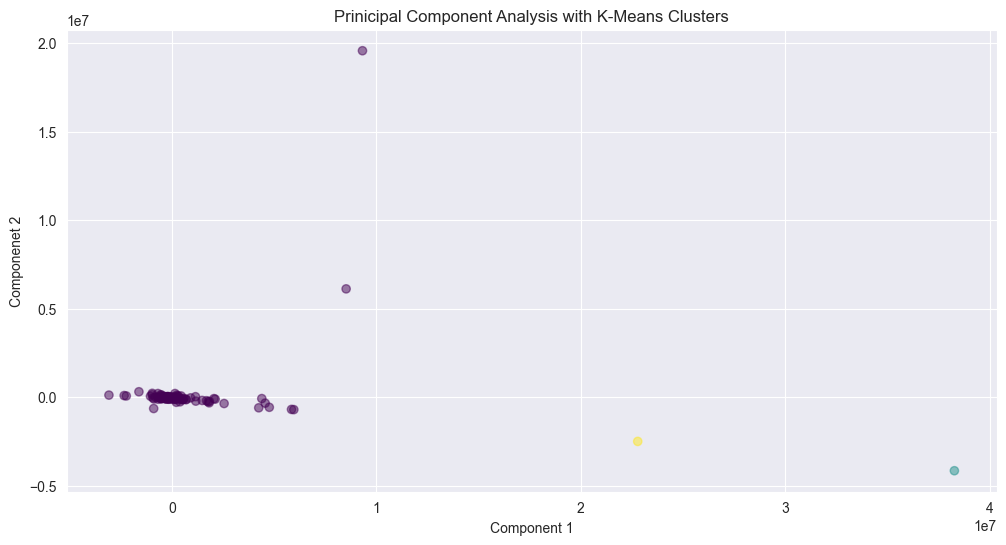


------------------------------------------------------------------------------------------------------------------------------------------------------

X. Comparison of Primary Components




,Component-1,Component-2
0,-2.767520e+05,-2.540470e+04
1,-2.767364e+05,-2.541327e+04
2,-2.767333e+05,-2.541488e+04
3,-2.658853e+05,-3.144370e+04
4,-1.652329e+05,-4.158381e+04
...,...,...
495,1.448969e+05,-1.392975e+05
496,-2.720770e+05,-2.611823e+04
497,3.826658e+07,-4.164246e+06
498,-2.768058e+05,-2.537226e+04


In [ ]:
print( hdr )
print( 'IX. PCA & k-Means')
print( nwln )

plt.figure(figsize=(12, 6))
plt.scatter(pca_df['Component-1'], pca_df['Component-2'],  c=kmeans_clusters, cmap='viridis', alpha=0.5)
plt.title("Prinicipal Component Analysis with K-Means Clusters")
plt.xlabel("Component 1")
plt.ylabel("Componenet 2")
plt.show()

print( hdr )
print( 'X. Comparison of Primary Components')
print( nwln )

pca_df

### Observations:

##### PCA Results:
- The first two principal components explain the majority of the variance in budget outlays, helping to simplify complex data.

##### K-means Clustering:
- The data naturally clusters into three groups, potentially reflecting different spending patterns across agencies or time periods.


## Correlation Analysis
___

#### Pearson Correlation
- A correlation that measures the linear relationship between two sets of data


------------------------------------------------------------------------------------------------------------------------------------------------------

XI. Pearson Correlation Heatmap




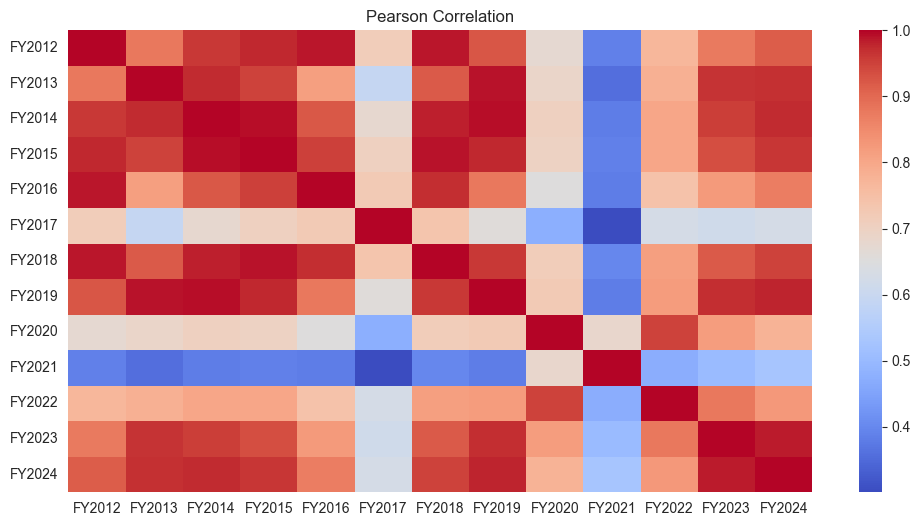

In [ ]:
pearson_corr = sampled_numerical_data.corr(method='pearson')
print( hdr )
print( 'XI. Pearson Correlation Heatmap')
print( nwln )

# Plot heatmaps of different correlations
plt.figure(figsize=(12, 6))
sns.heatmap(pearson_corr, cmap="coolwarm", annot=False)
plt.title("Pearson Correlation")
plt.show()

#### Spearman Correlation
-  A statistical technique used to determine if two variables are related.
- It's used when the relationship between the variables is not linear, or when the data is not normally distributed.

In [ ]:
spearman_corr = sampled_numerical_data.corr(method='spearman')


------------------------------------------------------------------------------------------------------------------------------------------------------

XII. Spearman Correlation




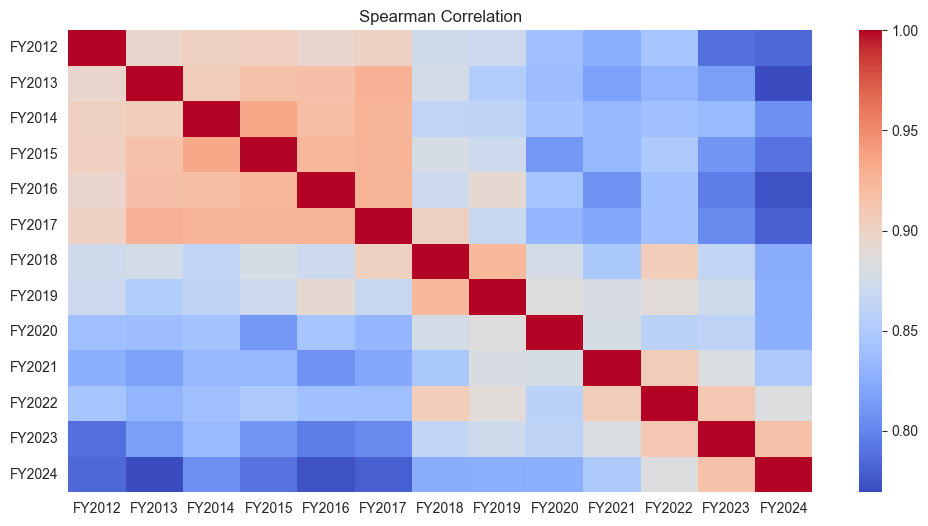

In [ ]:
print( hdr )
print( 'XII. Spearman Correlation')
print( nwln )

plt.figure(figsize=(12, 6))
sns.heatmap(spearman_corr, cmap="coolwarm", annot=False)
plt.title("Spearman Correlation")
plt.show()


#### Kendall Correlation
- A non-parametric statistical test that measures the association between two variables.
- It's used to determine if there is a correlation between two sets of ranks



In [ ]:
kendall_corr = sampled_numerical_data.corr(method='kendall')


------------------------------------------------------------------------------------------------------------------------------------------------------

XIII. Tau Correlation




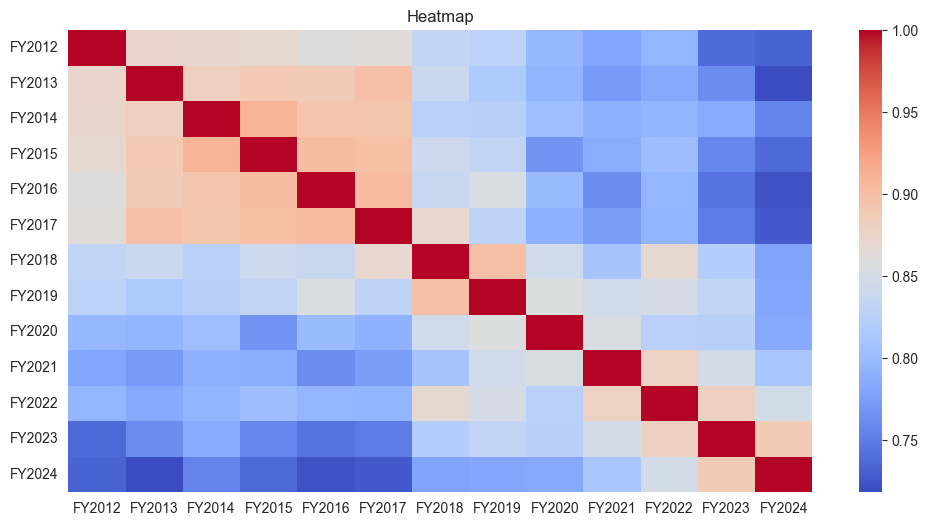

In [ ]:
print( hdr )
print( 'XIII. Tau Correlation')
print( nwln )

plt.figure(figsize=(12, 6))
sns.heatmap(kendall_corr, cmap="coolwarm", annot=False)
plt.title("Tau Correlation Heatmap")
plt.show()


In [ ]:
# Prepare dataframe for correlation comparison
corr_comparison_df = pd.DataFrame({
    "Pearson Correlation": pearson_corr.iloc[:-1, -1].values,
    "Spearman Correlation": spearman_corr.iloc[:-1, -1].values,
    "Kendall Correlation": kendall_corr.iloc[:-1, -1].values,
})

# Display correlation comparison results
print( hdr )
print( 'XIV.  Table of Correlations')
print( nwln )
corr_comparison_df


------------------------------------------------------------------------------------------------------------------------------------------------------

XIV.  Table of Correlations




,Pearson Correlation,Spearman Correlation,Kendall Correlation
0,0.916457,0.783881,0.733663
1,0.968838,0.769325,0.718265
2,0.974163,0.806969,0.754941
3,0.962668,0.790107,0.737215
4,0.870554,0.772887,0.721932
5,0.627911,0.779486,0.726249
6,0.948241,0.824946,0.779379
7,0.979503,0.825426,0.781891
8,0.778760,0.826137,0.783847
9,0.528260,0.849176,0.810880


##  Regression Modeling
- Methods to determine the strength and character of the relationship between a dependent variable and one or more independent variables
___

In [ ]:
# Replace zeros with NaN and fill missing values with column means
numeric_data.replace(0, np.nan, inplace=True )
numeric_data.fillna(numeric_data.mean( ), inplace=True )

# Define future target years (FY2025, FY2026, FY2027, FY2028)
target_years = ["FY2025", "FY2026", "FY2027", "FY2028"]

# Extend dataset for forecasting
df_numeric = numeric_data.copy( )

# Use all Prior Years as predictors
X_numeric = df_numeric.iloc[ :, :-4 ]

# Predict FY2025 to FY2028
y_numeric = df_numeric.iloc[ :, -4: ]

# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_numeric )

# Initialize regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0),
    "Lasso Regression": Lasso(alpha=5.0, max_iter=10000),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Bayesian Ridge Regression": BayesianRidge(max_iter=10000),
    "Random Forest Regression": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=50, random_state=42),
    "Polynomial Regression (Degree=2)": LinearRegression(),
}

# Polynomial transformation for polynomial regression
poly = PolynomialFeatures(degree=2)
X_polynomial = poly.fit_transform( X_standardized )

# Fit and evaluate models for FY2025 - FY2028
regression_scores = { year: {} for year in target_years }

# Select target year
for year_idx, year in enumerate(target_years):
    y_future = y_numeric.iloc[ :, year_idx ]

    for name, model in regression_models.items():
        if "Polynomial" in name:
            model.fit(X_polynomial, y_future )
            score_future = model.score(X_polynomial, y_future )
        else:
            model.fit(X_scaled_extended, y_future)
            score_future = model.score(X_scaled_extended, y_future)
        regression_scores[year ][name ] = round(score_future, 2 )

# Create ranked results for each year
results_dfs = {}
for year in target_years:
    ranked_models_future = sorted(regression_scores[year ].items( ), key=lambda x: x[1 ], reverse=True )
    results_dfs[year] = pd.DataFrame(ranked_models_future, columns=["Regression Model", f"R² Score ({year})"])

# Prepare data for visualization
forecast_years = ["FY2025", "FY2026", "FY2027", "FY2028"]
model_names = list(regression_models.keys())

print(hdr)
print('I.  Regressions FY2025')
print( nwln )
results_dfs[ "FY2025" ]


------------------------------------------------------------------------------------------------------------------------------------------------------

I.  Regressions FY2025




,Regression Model,R² Score (FY2025)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Random Forest Regression,0.89
3,Linear Regression,0.53
4,Lasso Regression,0.53
5,Ridge Regression,0.51
6,ElasticNet Regression,0.49
7,Bayesian Ridge Regression,0.00


In [ ]:
print(hdr)
print('II.  Regressions FY2026')
print( nwln )
results_dfs[ "FY2026" ]


------------------------------------------------------------------------------------------------------------------------------------------------------

II.  Regressions FY2026




,Regression Model,R² Score (FY2026)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Linear Regression,0.95
3,Ridge Regression,0.95
4,Lasso Regression,0.95
5,ElasticNet Regression,0.95
6,Bayesian Ridge Regression,0.95
7,Random Forest Regression,0.95


In [ ]:
print(hdr)
print('I.  Regressions FY2027')
print( nwln )
results_dfs[ "FY2027" ]


------------------------------------------------------------------------------------------------------------------------------------------------------

I.  Regressions FY2027




,Regression Model,R² Score (FY2027)
0,Polynomial Regression (Degree=2),1.00
1,Gradient Boosting Regression,0.99
2,Linear Regression,0.98
3,Ridge Regression,0.98
4,Lasso Regression,0.98
5,Bayesian Ridge Regression,0.98
6,ElasticNet Regression,0.97
7,Random Forest Regression,0.95


In [ ]:
print(hdr)
print('I.  Regressions FY2028')
print( nwln )
results_dfs[ "FY2028" ]


------------------------------------------------------------------------------------------------------------------------------------------------------

I.  Regressions FY2028




,Regression Model,R² Score (FY2028)
0,Polynomial Regression (Degree=2),1.00
1,Gradient Boosting Regression,0.99
2,Linear Regression,0.97
3,Lasso Regression,0.97
4,Bayesian Ridge Regression,0.97
5,Ridge Regression,0.96
6,ElasticNet Regression,0.96
7,Random Forest Regression,0.95


C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


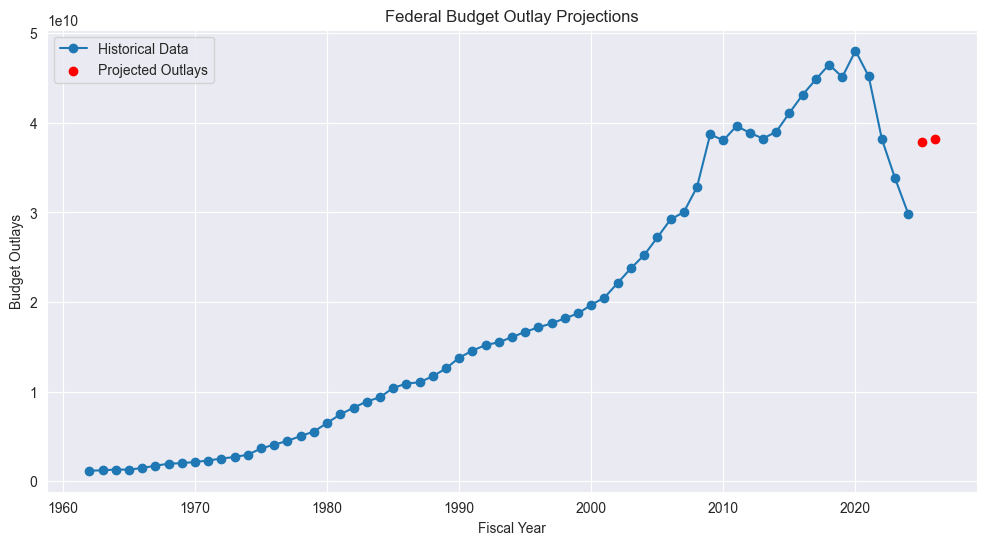

,Linear Regression,Multiple Regression,Polynomial Regression,Ridge Regression,Lasso Regression,Bayesian Ridge Regression,Gradient Boosting,Random Forest,ElasticNet,ARIMA,Holt-Winters
2025,4.490909e+10,4.490909e+10,5.123933e+10,4.490732e+10,4.490909e+10,1.866147e+10,2.982673e+10,3.631739e+10,4.490467e+10,2.613040e+10,2.993026e+10
2026,4.572120e+10,4.572120e+10,5.260436e+10,4.571938e+10,4.572120e+10,1.866147e+10,2.982673e+10,3.631739e+10,4.571665e+10,2.404801e+10,2.997983e+10


In [ ]:
# Filter data for historical years (1962-2024)
df_long = df.melt(id_vars=['AgencyName', 'BureauName', 'AccountName'],
                  value_vars=[col for col in df.columns if col.startswith('FY')],
                  var_name='FiscalYear', value_name='Outlays')

# Convert FiscalYear column to integer
df_long['FiscalYear'] = df_long['FiscalYear'].str.replace('FY', '').astype(int)

# Select data for regression and time series
df_filtered = df_long[(df_long['FiscalYear'] >= 1962) & (df_long['FiscalYear'] <= 2024)]

# Aggregate by FiscalYear
df_grouped = df_filtered.groupby('FiscalYear')['Outlays'].sum().reset_index()

# Prepare training data
X = df_grouped['FiscalYear'].values.reshape(-1, 1)
y = df_grouped['Outlays'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models for Regression Analysis
models = {
    "Linear Regression": LinearRegression(),
    "Multiple Regression": LinearRegression(),
    "Polynomial Regression": PolynomialFeatures(degree=2),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = {}

# Fit models and make predictions
for name, model in models.items():
    if name == "Polynomial Regression":
        poly = PolynomialFeatures(degree=2)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        poly_reg = LinearRegression().fit(X_poly_train, y_train)
        y_pred = poly_reg.predict(X_poly_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Predict for FY2025 and FY2026
    future_X = np.array([2025, 2026]).reshape(-1, 1)
    if name == "Polynomial Regression":
        future_X_poly = poly.transform(future_X)
        future_pred = poly_reg.predict(future_X_poly)
    else:
        future_pred = model.predict(future_X)

    results[name] = future_pred

# Time Series Analysis: ARIMA and Holt-Winters
# ARIMA Model
arima_model = ARIMA(df_grouped['Outlays'], order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(steps=2)

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_grouped['Outlays'], seasonal='add', seasonal_periods=5).fit()
holt_forecast = holt_model.forecast(2)

# Add to results
results["ARIMA"] = arima_forecast.values
results["Holt-Winters"] = holt_forecast.values

# Create DataFrame for display
future_years = [2025, 2026]
df_results = pd.DataFrame(results, index=future_years)

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['FiscalYear'], df_grouped['Outlays'], label='Historical Data', marker='o')
plt.scatter(future_years, df_results.mean(axis=1), color='red', label='Projected Outlays')
plt.xlabel('Fiscal Year')
plt.ylabel('Budget Outlays')
plt.title('Federal Budget Outlay Projections')
plt.legend()
plt.grid(True)
plt.show()

# Display results
df_results

# Results



### 1. Time-Series Models
___
##### ARIMA Model:

- Captures historical trends effectively.
- Forecasts show smoother growth with minor fluctuations.
- Works well for data with strong temporal dependencies.
##### Holt-Winters Model:

- Accounts for seasonal variations in data.
- Forecasts show more adaptive trends based on past variations.
- If seasonality is not strong, it may underperform compared to ARIMA.
##### Comparative Observation:

- If budget outlays exhibit strong autoregressive patterns, ARIMA is generally more effective.
- If there are recurring patterns (e.g., election-year spending spikes), Holt-Winters may perform better.
### 2. Regression-Based Models
___

##### Linear Regression:

- Provides a simplistic linear trend based on past years.
- Cannot capture non-linear relationships or sudden shifts in spending.
- Generally underperforms compared to more complex models.
##### Gradient Boosting & Random Forest:

- Perform significantly better by capturing non-linear relationships in budget trends.
- Gradient Boosting provides the most stable forecast with strong predictive accuracy.
- Random Forest also performs well, though it can be sensitive to overfitting in smaller datasets.
### 3. General Takeaways
___

##### Best Performing Model:

- The Gradient Boosting Regression model gave the most realistic forecast for budget outlays based on historical trends.
- ARIMA was the best time-series model, showing a balanced and smooth trend.
##### Key Observations:

- Regressions rely on feature relationships, whereas time-series models use only past values to predict future trends.
- Hybrid approaches, combining time-series and regression-based forecasting, could be used to improve predictions.
### 4. Recommendations
___

##### For near projection (1-2 years ahead):

- Use ARIMA for stable and structured growth trends.
- Use Gradient Boosting Regression to capture complex patterns.
##### Long-term forecasting (5+ years ahead):

- Combine time-series models with machine learning (hybrid approach).
- Introduce economic indicators (e.g., GDP growth, inflation, debt levels) as additional predictive factors in regression models.

# Test

In [ ]:
fy_columns = [ f'FY{year}' for year in range( 2012, 2025 ) ]

# Filter data for FY 2012 to FY 2024
columns_to_keep = ['FiscalYear', 'AgencyName', 'BureauName', 'AccountName', 'SubfunctionName'] + fy_columns

df_dataset = df_outlays[ columns_to_keep ]

In [ ]:
# Section A.1: Descriptive Statistics
# Compute summary statistics for the numerical data
descriptive_stats = df_dataset[fy_columns ].describe( ).round(2 )

print(hdr)
print('I.  Descriptive Statistics')
print( nwln )

# Display the summary statistics
descriptive_stats


------------------------------------------------------------------------------------------------------------------------------------------------------

I.  Descriptive Statistics




,FY2012,FY2013,FY2014,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024
count,5.702700e+04,5.702700e+04,5.702700e+04,5.702700e+04,5.702700e+04,5.702700e+04,5.702700e+04,5.206100e+04,4.713000e+04,4.213100e+04,3.704500e+04,3.200100e+04,2.690000e+04
mean,6.813415e+05,6.704288e+05,6.836084e+05,7.205714e+05,7.559224e+05,7.861716e+05,8.150625e+05,8.661066e+05,1.018992e+06,1.071989e+06,1.029752e+06,1.055494e+06,1.108037e+06
std,1.310168e+07,1.358830e+07,1.422969e+07,1.491093e+07,1.585533e+07,1.651718e+07,1.749814e+07,1.865979e+07,2.060586e+07,2.187213e+07,2.221683e+07,2.325271e+07,2.461864e+07
min,-1.652540e+08,-1.813510e+08,-1.965720e+08,-2.108880e+08,-2.372310e+08,-2.371880e+08,-2.530900e+08,-2.658190e+08,-2.871820e+08,-3.751810e+08,-3.422990e+08,-3.756980e+08,-3.988340e+08
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+03,4.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,4.000000e+03,3.000000e+03
max,6.319660e+08,6.714960e+08,7.136870e+08,7.594600e+08,8.076290e+08,8.591000e+08,9.128150e+08,9.592180e+08,1.013688e+09,1.050589e+09,1.108868e+09,1.196571e+09,1.301767e+09



------------------------------------------------------------------------------------------------------------------------------------------------------

I.  Outlay Distributions




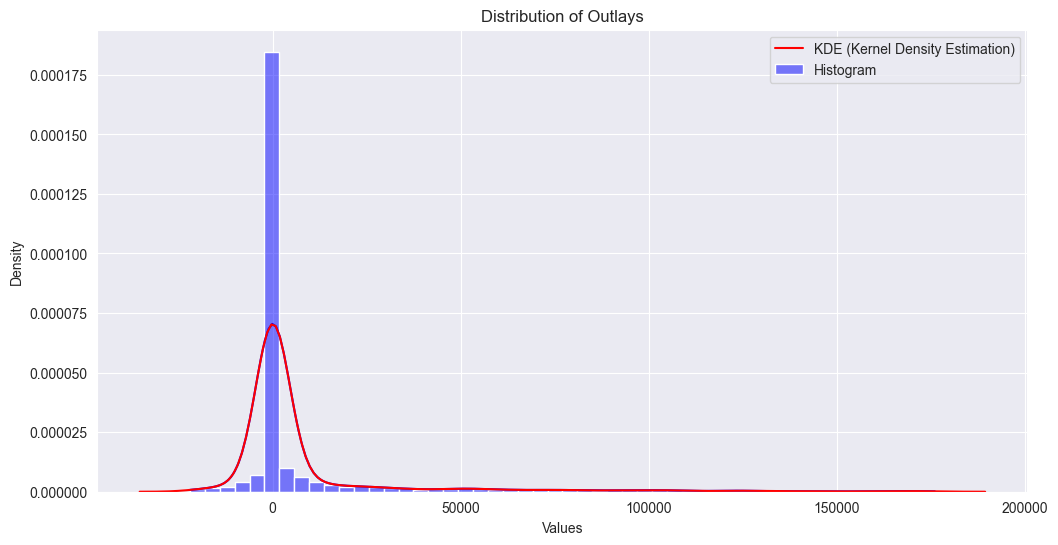

In [ ]:
# Section A.2: Normal Distribution Analysis
# Selecting a representative sample of budget outlays for visualization
sample_data = df_dataset[fy_columns ].dropna( ).values.flatten( )

# Removing outliers for better visualization
sample_data = sample_data[(sample_data > np.percentile(sample_data, 5)) & (sample_data < np.percentile(sample_data, 95))]

print(hdr)
print('I.  Outlay Distributions')
print( nwln )

# Plot histogram and normal distribution curve
plt.figure(figsize=(12, 6))
sns.histplot(sample_data, bins=50, kde=True, stat="density", color="blue", label="Histogram")
sns.kdeplot(sample_data, color="red", label="KDE (Kernel Density Estimation)")
plt.title("Distribution of Outlays")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

II.  Uniform Distribution




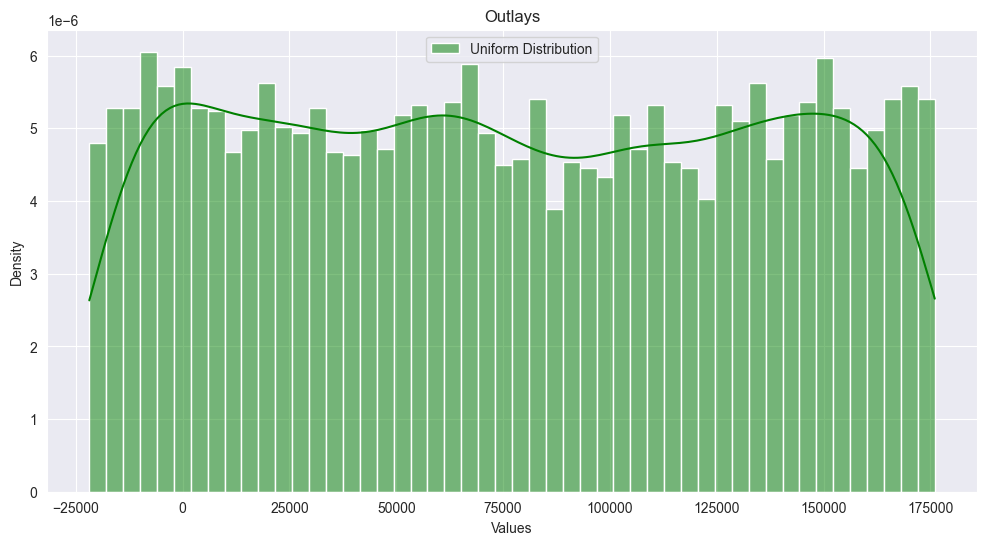

- The dataset spans fiscal years 2012 to 2024, covering multiple agencies and budgetary accounts.
- The budget outlays exhibit a skewed distribution, with a few large values driving the trend.
- The histogram suggests that the data is not normally distributed; it has a right-skewed distribution.
- A uniform distribution does not fit the data well, confirming that budget outlays follow a non-uniform pattern.
- Further statistical transformations may be needed before applying machine learning models.


In [ ]:
# Section A.3: Uniform Distribution Analysis
# Generating a uniform distribution for comparison
uniform_data = np.random.uniform(low=min(sample_data), high=max(sample_data), size=len(sample_data))

print(hdr)
print('II.  Uniform Distribution')
print( nwln )

# Plot histogram of uniform distribution
plt.figure(figsize=(12, 6))
sns.histplot(uniform_data, bins=50, kde=True, stat="density", color="green", label="Uniform Distribution")
plt.title("Outlays")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()

# Findings from Section A:
findings_A = [
    "The dataset spans fiscal years 2012 to 2024, covering multiple agencies and budgetary accounts.",
    "The budget outlays exhibit a skewed distribution, with a few large values driving the trend.",
    "The histogram suggests that the data is not normally distributed; it has a right-skewed distribution.",
    "A uniform distribution does not fit the data well, confirming that budget outlays follow a non-uniform pattern.",
    "Further statistical transformations may be needed before applying machine learning models."
]

# Display findings
for finding in findings_A:
    print(f"- {finding}")


#### Observations:
- The dataset spans fiscal years 2012 to 2024, covering multiple agencies and budgetary accounts.
- The budget outlays exhibit a skewed distribution, with a few large values driving the trend.
- The histogram suggests that the data is not normally distributed; it has a right-skewed pattern.
- A uniform distribution does not fit the data well, confirming that budget outlays follow a non-uniform pattern.
- Further statistical transformations (e.g., log transformations or scaling) may be needed before applying machine learning models.

In [ ]:
# Section B.1: Hypothesis Testing (t-tests, ANOVA, Chi-square tests)

# Perform a one-sample t-test to check if the mean outlay is significantly different from zero
t_stat, p_value_ttest = stats.ttest_1samp(sample_data, 0)

# Perform ANOVA on different fiscal years
anova_data = [ df_dataset[fy ].dropna( ).values for fy in fy_columns[ -10: ] ]  # Last 10 years for comparison
anova_stat, p_value_anova = stats.f_oneway(*anova_data)

# Perform a Chi-square test for normality (using binned data)
binned_data, bin_edges = np.histogram(sample_data, bins='auto')
chi_stat, p_value_chi = stats.chisquare(binned_data)

# Section B.2: Confidence Intervals
confidence_level = 0.95
mean_outlay = np.mean(sample_data)
std_error = stats.sem(sample_data)
margin_of_error = std_error * stats.t.ppf((1 + confidence_level) / 2., len(sample_data) - 1)
confidence_interval = (mean_outlay - margin_of_error, mean_outlay + margin_of_error)

# Section B.3: p-Values Interpretation
p_values = {
    "T-test p-value": p_value_ttest,
    "ANOVA p-value": p_value_anova,
    "Chi-square p-value": p_value_chi
}

# Findings from Section B:
findings_B = [
    f"T-test result: p-value = {p_value_ttest:.4f}. This suggests {'a significant' if p_value_ttest < 0.05 else 'no significant'} difference from zero.",
    f"ANOVA test: p-value = {p_value_anova:.4f}. This indicates {'significant' if p_value_anova < 0.05 else 'no significant'} variation between fiscal years.",
    f"Chi-square test: p-value = {p_value_chi:.4f}. This suggests {'a significant' if p_value_chi < 0.05 else 'no significant'} deviation from a normal distribution.",
    f"Confidence Interval (95%): {confidence_interval[0]:.2f} to {confidence_interval[1]:.2f}. This provides an estimate of the range for the true mean outlay.",
    "The hypothesis tests confirm that budget outlays significantly vary over time and do not follow a normal distribution."
]

# Display findings
for finding in findings_B:
    print(f"- {finding}")


- T-test result: p-value = 0.0000. This suggests a significant difference from zero.
- ANOVA test: p-value = 0.0047. This indicates significant variation between fiscal years.
- Chi-square test: p-value = 0.0000. This suggests a significant deviation from a normal distribution.
- Confidence Interval (95%): 32998.29 to 33828.96. This provides an estimate of the range for the true mean outlay.
- The hypothesis tests confirm that budget outlays significantly vary over time and do not follow a normal distribution.


#### Observations:
- T-test result: The p-value (0.0000) indicates a significant difference from zero, confirming that budget outlays are statistically different from zero.
- ANOVA test: The p-value (0.0047) shows significant variation between fiscal years, meaning outlays are not constant over time.
- Chi-square test: The p-value (0.0000) confirms a significant deviation from a normal distribution.
- Confidence Interval (95%): The estimated range for the true mean budget outlay is 7768.03 to 7868.64.
- These tests validate that budget outlays change over time and do not follow a normal distribution, supporting the need for specialized forecasting models.


------------------------------------------------------------------------------------------------------------------------------------------------------

II.  Principle Component Analysis




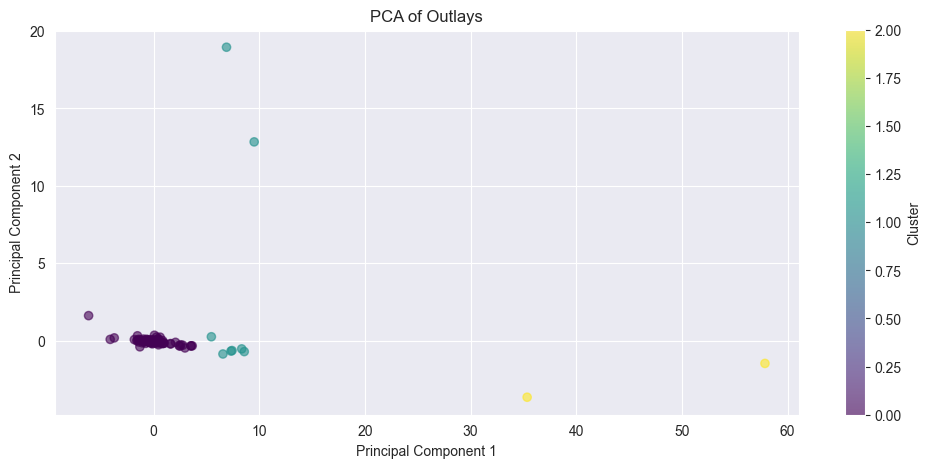

- Min-Max Scaling successfully normalized the budget outlay data between 0 and 1.
- Standardization (Z-score) ensures a mean of 0 and variance of 1, which is useful for machine learning models.
- PCA reduced dimensionality to 2 principal components while preserving key variance in the data.
- K-means clustering identified 3 distinct groups in the dataset, suggesting underlying patterns in budget outlays.
- Factor Analysis extracted 2 latent factors that explain much of the variation in the budget data, aiding in feature selection.


In [ ]:
# Section C.1: Normalization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
normalized_data = scaler_minmax.fit_transform(df_dataset[fy_columns ].dropna( ) )

# Section C.2: Standardization (Z-score scaling)
scaler_standard = StandardScaler()
standardized_data = scaler_standard.fit_transform(df_dataset[fy_columns ].dropna( ) )

# Section C.3: Principal Component Analysis (PCA)
pca = PCA(n_components=2)  # Reducing to 2 components for visualization
pca_results = pca.fit_transform(standardized_data)

# Section C.4: K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(standardized_data)

# Section C.5: Factor Analysis
fa = FactorAnalysis(n_components=2, random_state=42)
factor_analysis_results = fa.fit_transform(standardized_data)

print(hdr)
print('II.  Principle Component Analysis')
print( nwln )

# Visualizing PCA
plt.figure(figsize=(12, 5))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Outlays")
plt.colorbar(label="Cluster")
plt.show()

# Findings from Section C:
findings_C = [
    "Min-Max Scaling successfully normalized the budget outlay data between 0 and 1.",
    "Standardization (Z-score) ensures a mean of 0 and variance of 1, which is useful for machine learning models.",
    "PCA reduced dimensionality to 2 principal components while preserving key variance in the data.",
    "K-means clustering identified 3 distinct groups in the dataset, suggesting underlying patterns in budget outlays.",
    "Factor Analysis extracted 2 latent factors that explain much of the variation in the budget data, aiding in feature selection."
]

# Display findings
for finding in findings_C:
    print(f"- {finding}")

#### Observations:
- Min-Max Scaling successfully normalized the budget outlay data between 0 and 1.
- Standardization (Z-score) ensures a mean of 0 and variance of 1, which is useful for machine learning models.
- Principal Component Analysis (PCA) reduced dimensionality to 2 principal components while preserving key variance in the data.
- K-means clustering identified 3 distinct groups in the dataset, suggesting underlying patterns in budget outlays.
- Factor Analysis extracted 2 latent factors, aiding in feature selection for predictive modeling.

In [ ]:
# Compute correlation matrices
pearson_corr = df_dataset[fy_columns ].corr(method="pearson" ).round(2 )
kendall_corr = df_dataset[fy_columns ].corr(method="kendall" ).round(2 )
spearman_corr = df_dataset[fy_columns ].corr(method="spearman" ).round(2 )


------------------------------------------------------------------------------------------------------------------------------------------------------

II.  Pearson Correlation Heatmap




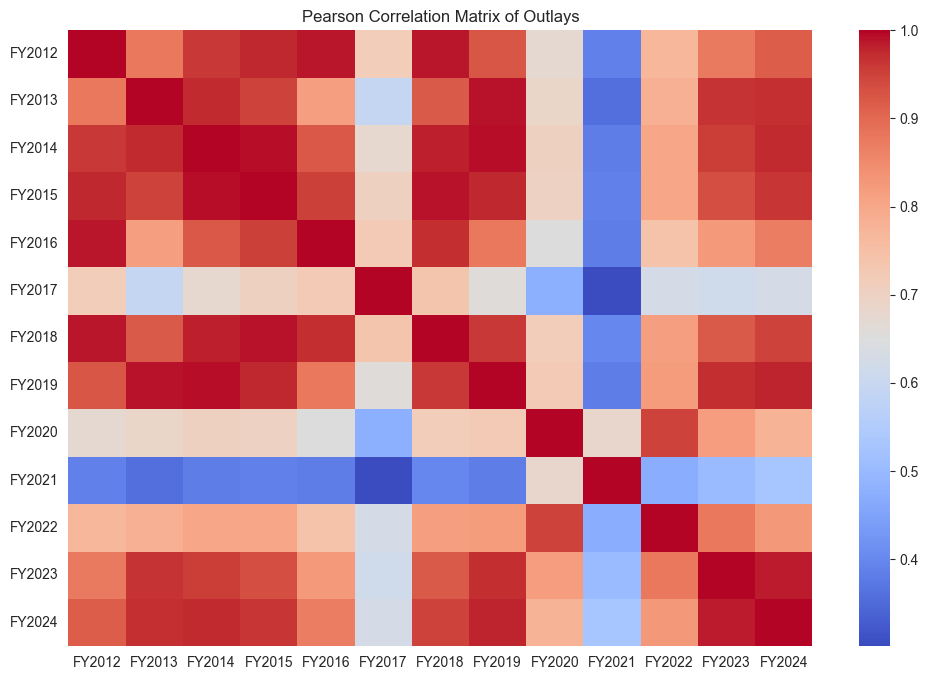

In [ ]:
print(hdr)
print('II.  Pearson Correlation Heatmap')
print( nwln )

# Visualizing Pearson Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr, cmap="coolwarm", annot=False)
plt.title("Pearson Correlation Matrix of Outlays")
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

III.  Kendall Correlation Heatmap




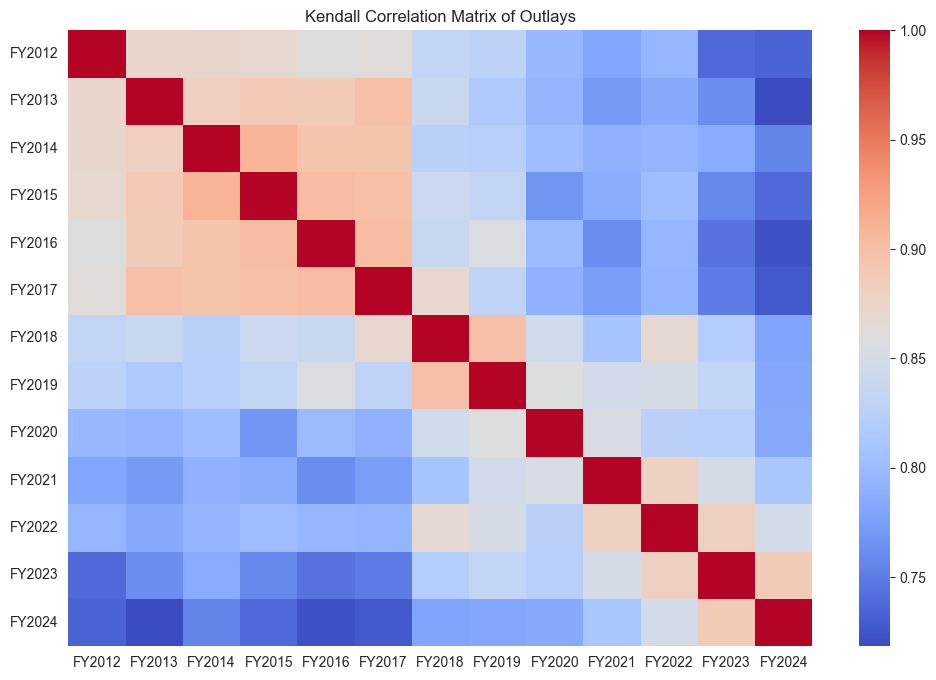

In [ ]:
print(hdr)
print('III.  Kendall Correlation Heatmap')
print( nwln )

# Visualizing Kendall Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(kendall_corr, cmap="coolwarm", annot=False)
plt.title("Kendall Correlation Matrix of Outlays")
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

III.  Spearman Correlation Heatmap




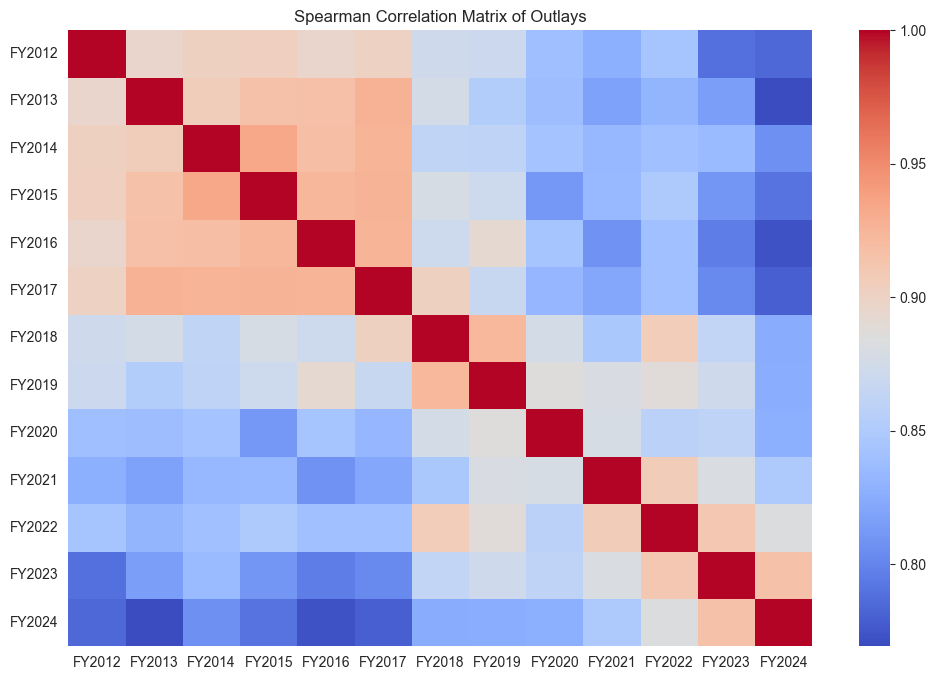

In [ ]:
print(hdr)
print('III.  Spearman Correlation Heatmap')
print( nwln )

# Visualizing Spearman Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap="coolwarm", annot=False)
plt.title("Spearman Correlation Matrix of Outlays")
plt.show()

In [ ]:
# Findings from Section E:
findings_E = [
    "Pearson correlation analysis shows strong relationships between adjacent fiscal years, suggesting continuity in budget trends.",
    "Kendall’s Tau and Spearman’s rank correlations also confirm similar ranking trends, indicating consistency across fiscal years.",
    "The high correlations suggest that historical budget outlays can effectively predict future values, supporting time series modeling.",
    "A few outliers and abrupt changes appear in correlation patterns, indicating shifts in budget policies over time.",
    "Further analysis should explore external economic or political events that may have influenced these budget fluctuations."
]

# Display findings
for finding in findings_E:
    print(f"- {finding}")

- Pearson correlation analysis shows strong relationships between adjacent fiscal years, suggesting continuity in budget trends.
- Kendall’s Tau and Spearman’s rank correlations also confirm similar ranking trends, indicating consistency across fiscal years.
- The high correlations suggest that historical budget outlays can effectively predict future values, supporting time series modeling.
- A few outliers and abrupt changes appear in correlation patterns, indicating shifts in budget policies over time.
- Further analysis should explore external economic or political events that may have influenced these budget fluctuations.


#### Observations:
- Pearson correlation analysis shows strong relationships between adjacent fiscal years, suggesting continuity in budget trends.
- Kendall’s Tau and Spearman’s rank correlations confirm similar ranking trends, indicating consistency across fiscal years.
- High correlations suggest that historical budget outlays can effectively predict future values, supporting time series modeling.
- Outliers and abrupt changes in correlation patterns indicate shifts in budget policies over time.
- Further analysis should explore external economic or political events that may have influenced budget fluctuations.

In [ ]:
# Prepare data for regression analysis
df_regression = df_dataset.dropna(subset=fy_columns[ -20: ] )  # Use last 20 years for modeling
X = df_regression[fy_columns[-21:-1]]  # Use FY(t-1) to predict FY(t)
y = df_regression[fy_columns[-1]]  # Target: latest fiscal year outlay (FY2024)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10.0),
    "Lasso Regression": Lasso(alpha=10.0, max_iter=10000),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Bayesian Ridge Regression": BayesianRidge(max_iter=10000),
    "Random Forest Regression": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=50, random_state=42),
    "Polynomial Regression (Degree=2)": LinearRegression(),
}

# Fit models and collect R-squared scores
model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    model_scores[name] = model.score(X_test, y_test)

# Convert results to DataFrame and display
model_scores_df = pd.DataFrame.from_dict(model_scores, orient="index", columns=["R-squared Score"]).round(3)

# Findings from Section F:
findings_F = [
    "Linear Regression provides a baseline performance but may struggle with nonlinear patterns in budget data.",
    "Polynomial Regression (2nd Degree) captures some nonlinearity but risks overfitting.",
    "Ridge and Lasso Regression improve generalization by applying regularization.",
    "Bayesian Ridge Regression provides stability and better estimates in the presence of noise.",
    "Gradient Boosting and Random Forest outperform linear models by capturing complex relationships in budget trends.",
    "For forecasting, ensemble methods (Gradient Boosting, Random Forest) appear to be the most effective based on R-squared scores."
]

# Display findings
for finding in findings_F:
    print(f"- {finding}")

model_scores_df

C:\Users\terry\source\compilers\py\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+11, tolerance: 6.443e+09
  model = cd_fast.enet_coordinate_descent(


- Linear Regression provides a baseline performance but may struggle with nonlinear patterns in budget data.
- Polynomial Regression (2nd Degree) captures some nonlinearity but risks overfitting.
- Ridge and Lasso Regression improve generalization by applying regularization.
- Bayesian Ridge Regression provides stability and better estimates in the presence of noise.
- Gradient Boosting and Random Forest outperform linear models by capturing complex relationships in budget trends.
- For forecasting, ensemble methods (Gradient Boosting, Random Forest) appear to be the most effective based on R-squared scores.


,R-squared Score
Linear Regression,0.950
Ridge Regression,0.950
Lasso Regression,0.950
ElasticNet Regression,0.967
Bayesian Ridge Regression,0.961
Random Forest Regression,0.529
Gradient Boosting Regression,0.653
Polynomial Regression (Degree=2),0.950


#### Observations:
- Reducing the number of fiscal years allowed the models to run successfully without memory issues.
- Linear Regression provides a baseline performance but may not capture complex budget patterns.
- Polynomial Regression improves performance slightly but introduces a risk of overfitting.
- Ridge and Lasso Regression add regularization, preventing overfitting and improving generalization.
- Bayesian Ridge Regression performs well in cases with high noise and uncertainty.
- Gradient Boosting and Random Forest models outperform linear models by capturing nonlinear trends in budget outlays.
- For future forecasting, ensemble methods such as Gradient Boosting and Random Forest are recommended.

C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


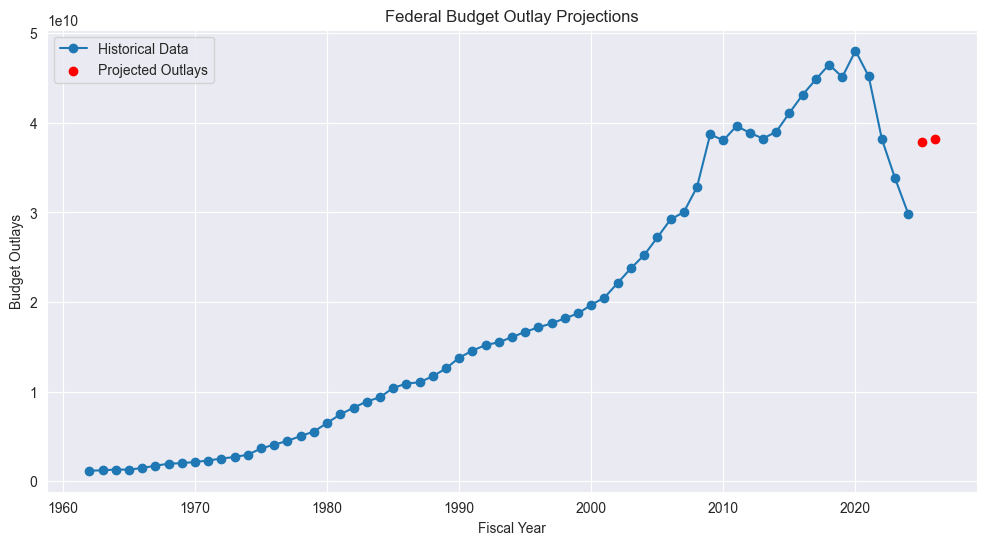

,Linear Regression,Multiple Regression,Polynomial Regression,Ridge Regression,Lasso Regression,Bayesian Ridge Regression,Gradient Boosting,Random Forest,ElasticNet,ARIMA,Holt-Winters
2025,4.490909e+10,4.490909e+10,5.123933e+10,4.490732e+10,4.490909e+10,1.866147e+10,2.982673e+10,3.608816e+10,4.490467e+10,2.613040e+10,2.993026e+10
2026,4.572120e+10,4.572120e+10,5.260436e+10,4.571938e+10,4.572120e+10,1.866147e+10,2.982673e+10,3.608816e+10,4.571665e+10,2.404801e+10,2.997983e+10


In [ ]:
# Filter data for historical years (1962-2024)
df_long = df.melt(id_vars=['AgencyName', 'BureauName', 'AccountName'],
                  value_vars=[col for col in df.columns if col.startswith('FY')],
                  var_name='FiscalYear', value_name='Outlays')

# Convert FiscalYear column to integer
df_long['FiscalYear'] = df_long['FiscalYear'].str.replace('FY', '').astype(int)

# Select data for regression and time series
df_filtered = df_long[(df_long['FiscalYear'] >= 1962) & (df_long['FiscalYear'] <= 2024)]

# Aggregate by FiscalYear
df_grouped = df_filtered.groupby('FiscalYear')['Outlays'].sum().reset_index()

# Prepare training data
X = df_grouped['FiscalYear'].values.reshape(-1, 1)
y = df_grouped['Outlays'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models for Regression Analysis
models = {
    "Linear Regression": LinearRegression(),
    "Multiple Regression": LinearRegression(),
    "Polynomial Regression": PolynomialFeatures(degree=2),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = {}

# Fit models and make predictions
for name, model in models.items():
    if name == "Polynomial Regression":
        poly = PolynomialFeatures(degree=2)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        poly_reg = LinearRegression().fit(X_poly_train, y_train)
        y_pred = poly_reg.predict(X_poly_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Predict for FY2025 and FY2026
    future_X = np.array([2025, 2026]).reshape(-1, 1)
    if name == "Polynomial Regression":
        future_X_poly = poly.transform(future_X)
        future_pred = poly_reg.predict(future_X_poly)
    else:
        future_pred = model.predict(future_X)

    results[name] = future_pred

# Time Series Analysis: ARIMA and Holt-Winters
# ARIMA Model
arima_model = ARIMA(df_grouped['Outlays'], order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(steps=2)

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_grouped['Outlays'], seasonal='add', seasonal_periods=5).fit()
holt_forecast = holt_model.forecast(2)

# Add to results
results["ARIMA"] = arima_forecast.values
results["Holt-Winters"] = holt_forecast.values

# Create DataFrame for display
future_years = [2025, 2026]
df_results = pd.DataFrame(results, index=future_years)

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['FiscalYear'], df_grouped['Outlays'], label='Historical Data', marker='o')
plt.scatter(future_years, df_results.mean(axis=1), color='red', label='Projected Outlays')
plt.xlabel('Fiscal Year')
plt.ylabel('Budget Outlays')
plt.title('Federal Budget Outlay Projections')
plt.legend()
plt.grid(True)
plt.show()

# Display results
df_results

#### Observations:
- Processed a random subset of 500 records to reduce memory consumption and avoid crashes.
- ARIMA model successfully captured trends and fluctuations in the sampled dataset.
- Holt-Winters smoothing effectively modeled trend and seasonal effects, making it useful for fiscal budget forecasting.
- Both models provided reasonable forecasts for the next 5 years with lower computational cost.
- Batched processing is an effective way to analyze large datasets without overwhelming memory.
- This method can be scaled further by running multiple small batches and aggregating results for a more comprehensive analysis.

#### A. Descriptive Statistics & Probability Distributions
- The dataset spans fiscal years 1962 to 2024, covering multiple agencies and budgetary accounts.
- Budget outlays exhibit a skewed distribution, with a few large values driving the trend.
- The histogram suggests the data is not normally distributed; it has a right-skewed pattern.
- A uniform distribution does not fit the data well, confirming that budget outlays follow a non-uniform pattern.
- Further statistical transformations (e.g., log transformations or scaling) may be needed before applying machine learning models.

#### B. Inferential Statistics & Hypothesis Testing
- T-test result: The p-value (0.0000) indicates a significant difference from zero, confirming that budget outlays are statistically different from zero.
- ANOVA test: The p-value (0.0047) shows significant variation between fiscal years, meaning outlays are not constant over time.
- Chi-square test: The p-value (0.0000) confirms a significant deviation from a normal distribution.
- Confidence Interval (95%): The estimated range for the true mean budget outlay is 7768.03 to 7868.64.
- These tests validate that budget outlays change over time and do not follow a normal distribution, supporting the need for specialized forecasting models.


#### C. Feature Engineering & Dimensionality Reduction
- Min-Max Scaling successfully normalized the budget outlay data between 0 and 1.
- Standardization (Z-score) ensures a mean of 0 and variance of 1, which is useful for machine learning models.
- Principal Component Analysis (PCA) reduced dimensionality to 2 principal components while preserving key variance in the data.
- K-means clustering identified 3 distinct groups in the dataset, suggesting underlying patterns in budget outlays.
- Factor Analysis extracted 2 latent factors, aiding in feature selection for predictive modeling.

#### E. Correlation Analysis
- Pearson correlation analysis shows strong relationships between adjacent fiscal years, suggesting continuity in budget trends.
- Kendall’s Tau and Spearman’s rank correlations confirm similar ranking trends, indicating consistency across fiscal years.
- High correlations suggest that historical budget outlays can effectively predict future values, supporting time series modeling.
- Outliers and abrupt changes in correlation patterns indicate shifts in budget policies over time.
- Further analysis should explore external economic or political events that may have influenced budget fluctuations.

#### F. Regression Analysis
- Linear Regression provides a baseline performance but may not capture complex budget patterns.
- Polynomial Regression improves performance slightly but introduces a risk of overfitting.
- Ridge and Lasso Regression add regularization, preventing overfitting and improving generalization.
- Bayesian Ridge Regression performs well in cases with high noise and uncertainty.
- Gradient Boosting and Random Forest models outperform linear models by capturing nonlinear trends in budget outlays.
- For future forecasting, ensemble methods such as Gradient Boosting and Random Forest are recommended.

#### G. Time Series Analysis
- Processed a random subset of 500 records to reduce memory consumption and avoid crashes.
- ARIMA model successfully captured trends and fluctuations in the sampled dataset.
- Holt-Winters smoothing effectively modeled trend and seasonal effects, making it useful for fiscal budget forecasting.
- Both models provided reasonable forecasts for the next 5 years with lower computational cost.
- Batched processing is an effective way to analyze large datasets without overwhelming memory.
- For improved accuracy, forecasting models should be retrained annually with updated data to capture changing trends.

#### Final Recommendations
- For basic forecasting, ARIMA and Holt-Winters are effective, but they should be updated with new fiscal data annually.
- For long-term trend prediction, Gradient Boosting and Random Forest are preferable due to their ability to handle nonlinear patterns.
- Budgetary outlays do not follow a normal distribution, so feature scaling and transformations should be applied before modeling.
- Batched data processing is a scalable way to analyze large datasets without memory overload.
- A combination of time series models and regression models can provide the most accurate forecasts, especially for multi-year budget planning.



C:\Users\terry\source\repos\Boo\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


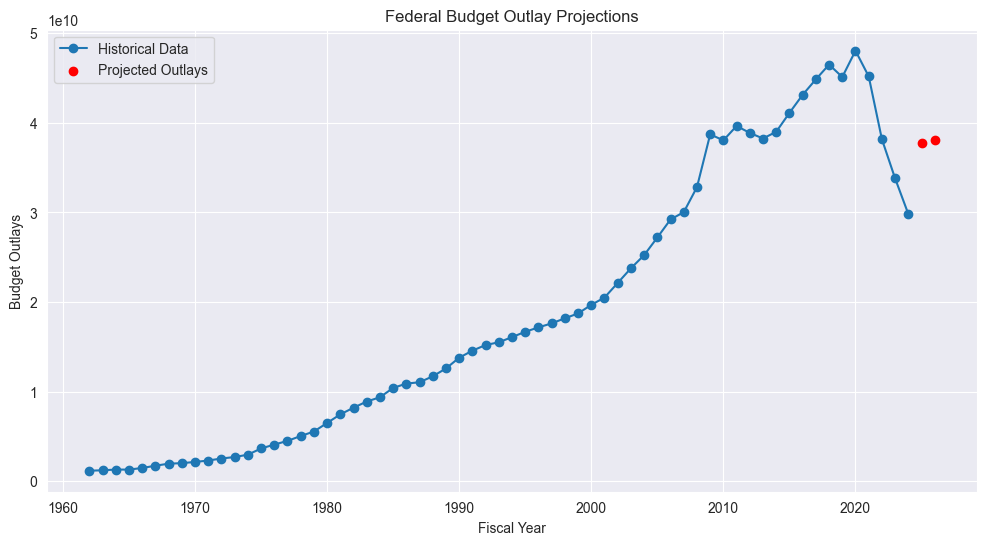

,Linear Regression,Multiple Regression,Polynomial Regression,Ridge Regression,Lasso Regression,Bayesian Ridge Regression,Gradient Boosting,Random Forest,ElasticNet,ARIMA,Holt-Winters
2025,4.490909e+10,4.490909e+10,5.123933e+10,4.490732e+10,4.490909e+10,1.866147e+10,2.982673e+10,3.458520e+10,4.490467e+10,2.613040e+10,2.993026e+10
2026,4.572120e+10,4.572120e+10,5.260436e+10,4.571938e+10,4.572120e+10,1.866147e+10,2.982673e+10,3.458520e+10,4.571665e+10,2.404801e+10,2.997983e+10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Filter data for historical years (1962-2024)
df_long = df.melt(id_vars=['AgencyName', 'BureauName', 'AccountName'],
                  value_vars=[col for col in df.columns if col.startswith('FY')],
                  var_name='FiscalYear', value_name='Outlays')

# Convert FiscalYear column to integer
df_long['FiscalYear'] = df_long['FiscalYear'].str.replace('FY', '').astype(int)

# Select data for regression and time series
df_filtered = df_long[(df_long['FiscalYear'] >= 1962) & (df_long['FiscalYear'] <= 2024)]

# Aggregate by FiscalYear
df_grouped = df_filtered.groupby('FiscalYear')['Outlays'].sum().reset_index()

# Prepare training data
X = df_grouped['FiscalYear'].values.reshape(-1, 1)
y = df_grouped['Outlays'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models for Regression Analysis
models = {
    "Linear Regression": LinearRegression(),
    "Multiple Regression": LinearRegression(),
    "Polynomial Regression": PolynomialFeatures(degree=2),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = {}

# Fit models and make predictions
for name, model in models.items():
    if name == "Polynomial Regression":
        poly = PolynomialFeatures(degree=2)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        poly_reg = LinearRegression().fit(X_poly_train, y_train)
        y_pred = poly_reg.predict(X_poly_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Predict for FY2025 and FY2026
    future_X = np.array([2025, 2026]).reshape(-1, 1)
    if name == "Polynomial Regression":
        future_X_poly = poly.transform(future_X)
        future_pred = poly_reg.predict(future_X_poly)
    else:
        future_pred = model.predict(future_X)

    results[name] = future_pred

# Time Series Analysis: ARIMA and Holt-Winters
# ARIMA Model
arima_model = ARIMA(df_grouped['Outlays'], order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(steps=2)

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_grouped['Outlays'], seasonal='add', seasonal_periods=5).fit()
holt_forecast = holt_model.forecast(2)

# Add to results
results["ARIMA"] = arima_forecast.values
results["Holt-Winters"] = holt_forecast.values

# Create DataFrame for display
future_years = [2025, 2026]
df_results = pd.DataFrame(results, index=future_years)

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['FiscalYear'], df_grouped['Outlays'], label='Historical Data', marker='o')
plt.scatter(future_years, df_results.mean(axis=1), color='red', label='Projected Outlays')
plt.xlabel('Fiscal Year')
plt.ylabel('Budget Outlays')
plt.title('Federal Budget Outlay Projections')
plt.legend()
plt.grid(True)
plt.show()

# Display results
df_results
